# Convolutional NN

In [1]:
import numpy as np
import gzip
import os
import pickle
from matplotlib import pyplot
from si.data import Dataset, LabelEncoder, OneHotEncoder

## Load and preprocess the MNIST dataset

In [2]:
def load_mnist(sample_size=None):
    DIR = os.path.dirname(os.path.realpath('.'))
    filename = os.path.join(DIR, 'datasets/mnist.pkl.gz')
    f = gzip.open(filename, 'rb')
    data = pickle.load(f, encoding='bytes')
    (x_train, y_train), (x_test, y_test) = data
    if sample_size:
        return Dataset(x_train[:sample_size],y_train[:sample_size]),Dataset(x_test,y_test)
    else:
        return Dataset(x_train,y_train),Dataset(x_test,y_test)

In [3]:
train,test = load_mnist(500)

In [4]:
def preprocess(train):
    # reshape and normalize input data 
    train.X = train.X.reshape(train.X.shape[0], 28, 28, 1)
    train.X = train.X.astype('float32')
    train.X /= 255
    LabelEncoder().fit_transform(train, inline=True)
    OneHotEncoder().fit_transform(train, inline=True)

In [5]:
preprocess(train)
preprocess(test)

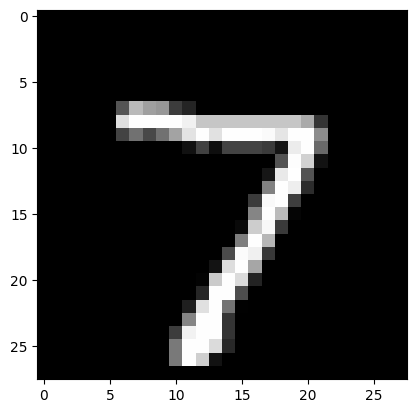

In [6]:
def plot_img(img,shape=(28,28)):
    pic = (img*255).reshape(shape)
    pic = pic.astype('int')
    pyplot.imshow(pic, cmap=pyplot.get_cmap('gray'))
    pyplot.show()

plot_img(test.X[0])

In [7]:
from si.supervised.nn import (NN, Dense, Conv2D, 
                              Flatten, MaxPooling2D, 
                              Dropout, Tanh, Sigmoid, Adam)
from si.util import multiclass_accuracy

### Check Conv2D

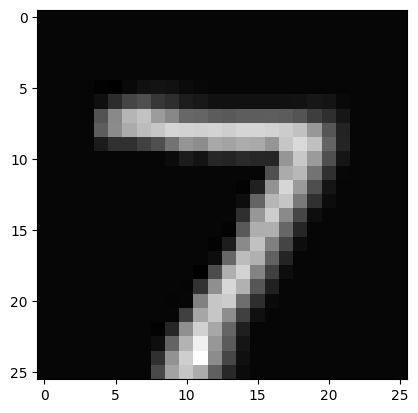

In [8]:
conv = Conv2D((28, 28,1), (3, 3), 1)
conv.initialize()
out = conv.forward(test.X[:1])
plot_img(out, shape=(26, 26))


### Check MaxPooling

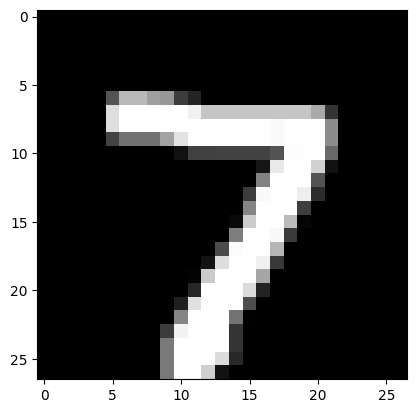

In [9]:
pool = MaxPooling2D(size=2,stride=1)
out = pool.forward(test.X[:1])
plot_img(out, shape=(27, 27))


# Build and train the model

In [10]:
adam = Adam()
net = NN(optimizer= adam,
         loss='cross-entropy',
         metric=multiclass_accuracy,
         verbose=False,
         step=1)

net.add(Conv2D((28, 28,1), (3, 3), 1))  
net.add(Tanh())

net.add(MaxPooling2D())
net.add(Flatten())

net.add(Dense(25*25*1, 100))
net.add(Tanh())

net.add(Dense(100, 10))                
net.add(Sigmoid())

Train the model

In [11]:
net.fit(train, epochs=1000, batch_size=64)

## Apply the model to the test set

In [12]:
out = net.predict(test.X[:])
print("\n")
print("Predicted values:")
p = np.argmax(out,axis=1)
print(p, end="\n")
print("True values:")
t= np.argmax(test.y[:],axis=1)
print(t)
e = p-t
count = np.count_nonzero(e == 0)
print('Percentage of correct predictions:', count/e.shape[0])



Predicted values:
[7 2 1 ... 4 8 6]
True values:
[7 2 1 ... 4 5 6]
Percentage of correct predictions: 0.8552


In [13]:
conv1 = net.layers[0]
act1 = net.layers[1]
pool1 = net.layers[2]

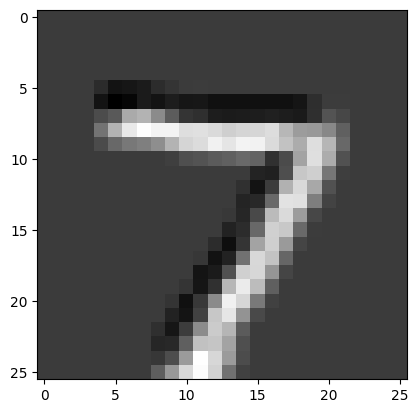

In [14]:
img1 = conv1.forward(test.X[:1])
plot_img(img1,shape=(26,26))


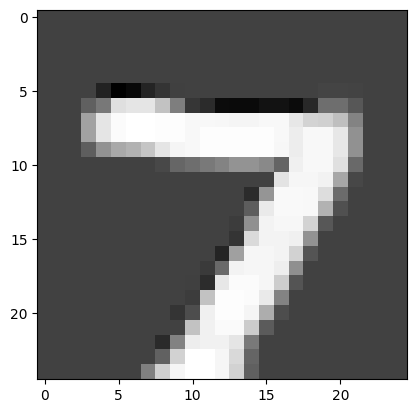

In [15]:
img2= pool1.forward(act1.forward(img1))
plot_img(img2,shape=(25,25))

## Learning curves

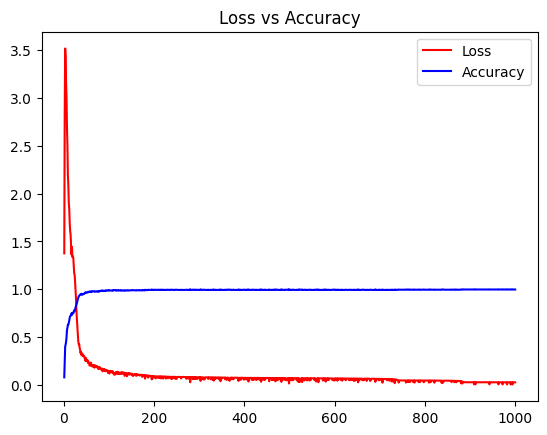

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(list(net.history.keys()), 
         [x[0] for x in net.history.values()], 
         '-', color='red', label='Loss')
plt.plot(list(net.history.keys()), 
         [x[1] for x in net.history.values()], 
         '-', color='blue', label='Accuracy')
plt.title('Loss vs Accuracy')
plt.legend()
plt.show()